In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

# uplifitng

### 데이터 변수 설명
* recency : 마지막 구매 후 개월
* history: 과거 구매의 $value
* used_discount: 할인 사용 여부
* used_bogo: 재구매 했는지 여부
* zip_code: Suburban/Urban/Rural과 같은 우편번호 클래스
* is_referral: 추천 채널에서 고객을 획득했는지 여부를 나타냅니다.
* channel: 고객이 사용하는 채널, Phone/Web/Multichannel
* offer: 고객에게 전송된 제안, Discount/But One Get One(원플러스원)/No Offer
* conversation : (1-구매 , 0-X)

### Content

This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25

----
* 데이터 설명에 따르면 discount 나 bogo offer를 받은 고객들은 Treatment(타겟군) 이고 나머지는 통제집단으로 볼 수 있겠다.



In [ ]:
# !kaggle datasets download -d davinwijaya/customer-retention
!unzip -o /content/customer-retention.zip -d /content

Archive:  /content/customer-retention.zip
  inflating: /content/data.csv       


In [26]:
df= pd.read_csv('/content/uplift.csv')

실험군과 대조군에 대한 정보가 좀 헷갈린다.


In [27]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


# 데이터탐색

In [ ]:
df.info()

In [ ]:
# 범주형 변수 확인
df.describe(include = np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


## EDA
 Object 컬럼


In [ ]:
df.select_dtypes

In [28]:
def plot_object_columns(df,obejct_columns):
    object_columns = obejct_columns
    # df.select_dtypes(include=['object']).columns

    num_cols = len(object_columns)
    num_rows = 1  # Number of rows for subplots
    figsize = (5 * num_cols, 5)  # Adjust the figure size based on the number of columns

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(object_columns):
        ax = axes[i] if num_cols > 1 else axes  # Handle single subplot case
        sns.countplot(x=col, data=df, palette="coolwarm_r", order=df[col].value_counts().index, ax=ax)
        ax.set_title(f'Counts for {col}', fontsize=10)
        ax.set_xlabel(col)  # Set xlabel for better readability
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

        # Print value percentages
        percentages = df[col].value_counts() / len(df) * 100
        print(percentages, df[col].value_counts())

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Assuming you have a DataFrame named 'df'
# plot_object_columns(df)


연속형 변수

In [ ]:
plt.hist(df['history'], bins=50)  # 20개의 구간으로 나누어 히스토그램 그리기
plt.title('Distribution of history')
plt.show()


## 가설 검정

In [29]:
# 실험군,대조군 treatment 컬럼을 따로 만들어주자
df['treatment'] = 0
df.loc[df['offer'].isin(['Buy One Get One', 'Discount']), 'treatment'] = 1


In [30]:
df.offer = df.offer.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1}) # 0 인경우 control, -1,1 인경우 Treatment


In [32]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,treatment
0,10,142.44,1,0,Surburban,0,Phone,-1,0,1
1,6,329.08,1,1,Rural,1,Web,0,0,0
2,7,180.65,0,1,Surburban,1,Web,-1,0,1
3,9,675.83,1,0,Rural,1,Web,1,0,1
4,2,45.34,1,0,Urban,0,Web,-1,0,1
...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0,1
63996,5,38.91,0,1,Urban,1,Phone,1,0,1
63997,6,29.99,1,0,Urban,1,Phone,1,0,1
63998,1,552.94,1,0,Surburban,1,Multichannel,-1,0,1


In [50]:
df_bogo = df.copy().loc[df.offer <=0].reset_index(drop=True)
df_discount = df.copy().loc[df.offer >= 0 ].reset_index(drop=True)


df_treat_bogo = df_bogo.groupby(['treatment']).agg({'conversion':['mean','sum','count']})
df_treat_discount = df_discount.groupby(['treatment']).agg({'conversion':['mean','sum','count']})

print(df_treat_bogo)
print(df_treat_discount)



          conversion             
                mean   sum  count
treatment                        
0           0.106167  2262  21306
1           0.151400  3238  21387
          conversion             
                mean   sum  count
treatment                        
0           0.106167  2262  21306
1           0.182757  3894  21307


In [47]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(count=df_treat_discount.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=df_treat_discount.reset_index()[('conversion')]['count'].loc[:1])[1]

5.685165482802317e-112

* treatment(-1) = BOGO 원플러스원 광고를 받은 실험군
* treatment(1) = 할인 광고를 받은 실험군
* treatment(0) = 대조군



In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Calculate the number of successes (converted) and the total counts for the first two rows
successes = df_treat_discount.reset_index()[('conversion')]['sum'].loc[:1]
counts = df_treat_discount.reset_index()[('conversion')]['count'].loc[:1]

# Perform the z-test using proportions_ztest
_, p_value = proportions_ztest(count=successes, nobs=counts)

print(f"p-value: {p_value}")


p-value: 5.685165482802317e-112


마케팅 제안으로 BOGO 와 Dsicount를 나눠서보면 1:1:1 비율이지만
전체적으로 실험군이 대조군보다 2배이상 많다.


## encoding

In [ ]:
# 업리프팅 모델로 구간을 나누기전, treatment 와 target의 여부로 업리프팅 세그먼트를 나눌 수 있다.

#CN:
df['target_class'] = 0
#CR:
df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
#TN:
df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
#TR:
df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3

df['target_class'].value_counts()

In [52]:
# 범주형 변수 one hot encoding
df_model = pd.get_dummies(df)


In [53]:
# target 변수
df_bogo = df_model.copy().loc[df_model.offer <=0].reset_index(drop=True) # 원플원 광고를 받은 실험군과 대조군 DATA
df_discount = df_model.copy().loc[df_model.offer >=0].reset_index(drop=True) # 할인 광고를 받은 실험군과 대조군 DATA

In [74]:
print(len(df_discount))
print(len(df_bogo))

42613
42693


## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

In [55]:
train, test  = train_test_split(df_discount, test_size=0.2, random_state=42, stratify = df_discount['treatment'])

# 주어진 피처 리스트
features = ['recency',	'history',	'used_discount',	'used_bogo',	'is_referral'	,	'zip_code_Rural',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Multichannel',	'channel_Phone'	,'channel_Web']

# 피처 및 타겟을 설정하고 데이터를 분할
X = train[features]  # train 데이터프레임을 사용하여 피처 추출
y = train['conversion']
treatment = train['treatment']

# 데이터 분할
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

In [9]:
!pip install scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.2 MB/s eta 0:00:00


[LightGBM] [Info] Number of positive: 1449, number of negative: 12173
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13622, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106372 -> initscore=-2.128347
[LightGBM] [Info] Start training from score -2.128347
[LightGBM] [Info] Number of positive: 2469, number of negative: 11181
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13650, number of used features: 11
[LightGBM] [Info

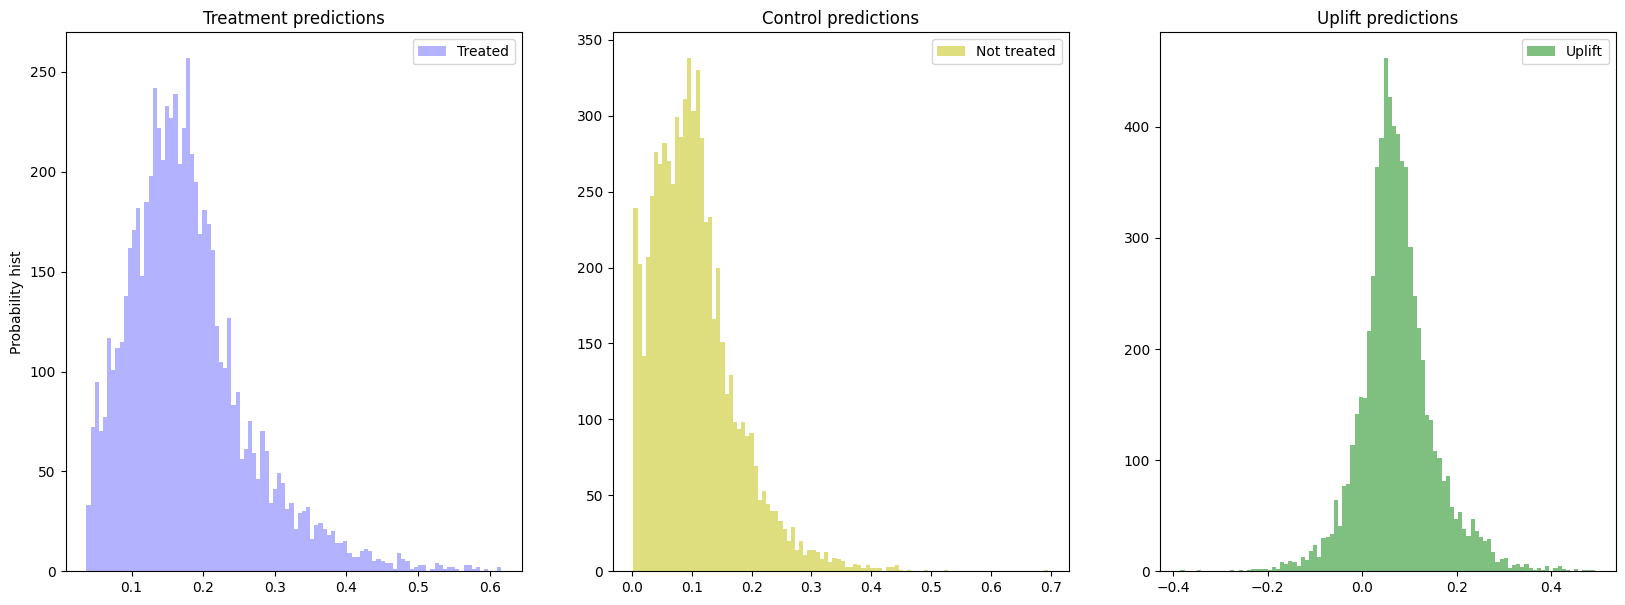

In [56]:
import lightgbm as lgb

from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds


models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels 모델 설정
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. 모델 학습
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. 업리프팅 예측
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# 5. 업리프팅 측정
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

마케팅 으로 bogo 를 이용한 경우 , [Uplift predictions] 전반적으로 정규분포형태를 띄고있다. 0이상의 스코어를 갖는 고객군들이 많아보이는데 한번 봐보자!

In [ ]:
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

In [57]:
df_discount = df_discount[features]
uplift_full = tm.predict(df_discount)  # 적용
df_discount['score'] = uplift_full

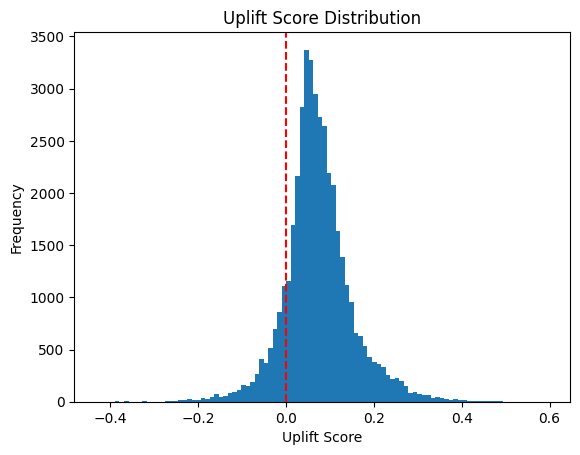

In [60]:
plt.hist(df_discount['score'], bins=100)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Uplift')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [ ]:
df_discount

In [61]:
# score 가 0 이상인

score_count = df_discount[df_discount['score'] >= 0]['score'].count()
total_count = len(df_discount)

positive_score_ratio = score_count / total_count
print("Positive Score Ratio:", positive_score_ratio)


Positive Score Ratio: 0.8738413160303193


In [66]:
# 임계값 설정
threshold = 0.2

# Pesuadables 그룹으로 간주되는 데이터 개수 계산
pesuadables_count = len(df_discount[df_discount['score'] >= threshold])

# 전체 데이터 개수
total_count = len(df_discount)

# Pesuadables 그룹의 비율 계산
pesuadables_ratio = pesuadables_count / total_count

print("Pesuadables 그룹 비율:", pesuadables_ratio)
print(total_count)

Pesuadables 그룹 비율: 0.06162438692417807
42613


###  score를 기준으로 세그먼트를 어떻게 나눠야하지?

>✔️ skewness 는 높지 않지만 약 87% 유저의 score가 0.0 이상을 기록했다.
업리프팅 사분면에 따라 세그먼터를 나눠야하는데, 어떤 기준으로 나눠야할까..?

> score 가 높을 수록 Pesuadables 고객으로 봐야하는것 같은데  그 높다는 기준을 어디로 잡아야 하는지 헷갈린다!

### 🤔결론!
일단 크게 치우쳐지지 않고,
* score 가 0 이상인경우 87%
* 0.1 인경우, 23%
* 0.2 인 경우 2.5%
* 0.3 부터는 0.2 %로 매우 적다.
* scroe가 음수인 경우는 13% 가 있음.

크게 4가지로 분류할 수 는 없을 것 같지만, 확실한건 해당 광고시 부정적인 영향을 끼칠 세그먼트는 확실히 나눌 수 있다는것!

> 일단은 0 =< surething < 0.1  인경우 SureThings \
0.1 이상인경우 Persuadables , 음수인경우 Lost Causes 로 나누었다.



In [77]:
def segment_customers(score):
    if score >= 0 and score < 0.1:
        return "Sure Things"
    elif score >= 0.1:
        return "Persuadables"
    elif score >= -0.1 and score < 0:
        return "Lost Causes"
    else:
        return "Sleeping dogs"

df_discount['segment'] = df_discount['score'].apply(segment_customers)
df_discount['segment'].value_counts()

Sure Things      24450
Persuadables     12787
Lost Causes       4614
Sleeping dogs      762
Name: segment, dtype: int64

Sure Things      57.376857
Persuadables     30.007275
Lost Causes      10.827682
Sleeping dogs     1.788187
Name: segment, dtype: float64 Sure Things      24450
Persuadables     12787
Lost Causes       4614
Sleeping dogs      762
Name: segment, dtype: int64


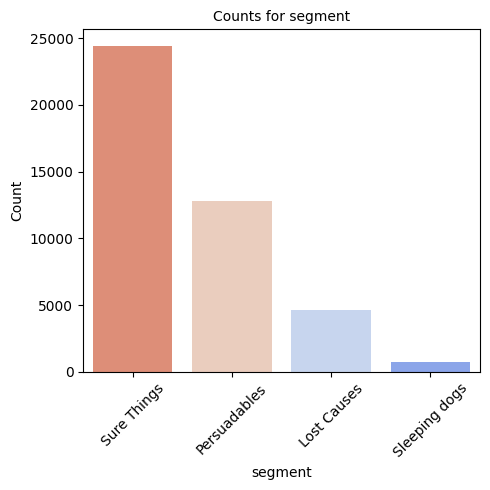

In [78]:
plot_object_columns(df_discount,['segment'])

# 결과
uplift score를 기준으로 42613명의 오디언스를 아래와 같이 네 개의 세그먼트로 구분한 결과

||오디언스규모|
|:---:|:---:|
|Sure Things|24450|
|Persuadables |12787|
|Lost Causes |4614|
|Sleeping dogs|762|

앞 포스팅에서 설명한 분류 이론에 따르면, 앞서 진행한 할인 캠페인 오디언스 중 광고 증대효과가 큰 고객들은 `Pesuadables` 고객들입니다.

>* 만약 전체 고객들을 타겟해서 광고를 했을 시
100 * 42613 = 4,261,300 원
* `Pesuadables`  고객들만 타겟해서 광고를 했을 시  
100 * 12787 = 1,278,700 원


>*  모든 고객들에게 광고비를 쓰지 않고, **광고 증대효과가 클거라고 예측된 고객들**에게만 사용시, 약 **70%, 2,982,600원** **절감**할 수 있습니다.
* 해당 캠페인을 특히 **피해서 진행해야하는 고객들**의 경우 5,376 명입니다! 위 고객들만 제외해서 캠페인을 진행 시켜도 **537,600원** **절감**할 수 있습니다.

In [81]:
df_discount_a = df.copy().loc[df.offer >= 0 ].reset_index(drop=True)
df_discount_a

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,treatment
0,6,329.08,1,1,Rural,1,Web,0,0,0
1,9,675.83,1,0,Rural,1,Web,1,0,1
2,9,675.07,1,1,Rural,1,Phone,1,0,1
3,2,101.64,0,1,Urban,0,Web,1,1,1
4,4,241.42,0,1,Rural,1,Multichannel,0,0,0
...,...,...,...,...,...,...,...,...,...,...
42608,7,86.46,0,1,Urban,0,Web,1,0,1
42609,10,105.54,1,0,Urban,0,Web,1,0,1
42610,5,38.91,0,1,Urban,1,Phone,1,0,1
42611,6,29.99,1,0,Urban,1,Phone,1,0,1


In [ ]:
df_discount_a['segement'] = df_discount['segment']
df_discount_a

In [ ]:
df_persu = df_discount_a[df_discount_a['segement'] == 'Persuadables']
df_sure = df_discount_a[df_discount_a['segement'] == 'Sure Things']

df_persu

In [ ]:
plot_object_columns(df_persu,['used_bogo','zip_code','used_discount','used_bogo','channel','recency'])